# **Programming for Applied Deep Learning (GKSG008-01)**
> ### **20181202 김수미**
> ### LeNet_with_Conv2d(4) (Based on 11/23 Lecture)

1. Choose two of AlexNet, VGG-Net, NiN, or you may try all of them.

 

2. Train CIFAR10, and compare the two (or three) accuracies from the networks. You may use different set of hyperparameters such as learning rate, n_epochs, etc.

 

3. Do the same for CIFAR100 dataset.

 

4. Visualize a few training images together with their class names, for CIFAR10 and CIFAR100, respectively.

> ### **0. Import Libraries and Define Functions**

In [ ]:
pip install d2l

In [2]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.utils.data as data
import warnings
warnings.filterwarnings('ignore')

from d2l.torch import *
from torch import nn
from d2l import torch as d2l
from torch.utils.data import DataLoader

In [3]:
def load_data_cifar10(batch_size, resize=None):
    trans = [transforms.ToTensor()]
    if resize:
      trans.insert(0,transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.CIFAR10(root="../data",train=True,transform=trans,download=True)
    mnist_test = torchvision.datasets.CIFAR10(root="../data",train=False,transform=trans,download=True)
    return(data.DataLoader(mnist_train,batch_size,shuffle=True,num_workers=4),
           data.DataLoader(mnist_test,batch_size,shuffle=False,num_workers=4))

In [4]:
def load_data_cifar100(batch_size, resize=None):
    trans = [transforms.ToTensor()]
    if resize:
      trans.insert(0,transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.CIFAR100(root="../data",train=True,transform=trans,download=True)
    mnist_test = torchvision.datasets.CIFAR100(root="../data",train=False,transform=trans,download=True)
    return(data.DataLoader(mnist_train,batch_size,shuffle=True,num_workers=4),
           data.DataLoader(mnist_test,batch_size,shuffle=False,num_workers=4))

In [5]:
def evaluate_accuracy_gpu(net, data_iter, device=None):
  if isinstance(net, nn.Module):
    net.eval()
    if not device:
      device = next(iter(net.parameters())).device
  metric = d2l.Accumulator(2)

  with torch.no_grad():
    for X, y in data_iter:
      if isinstance(X, list):
        X = [x.to(device) for x in X]
      else:
        X = X.to(device)
      y = y.to(device)
      metric.add(d2l.accuracy(net(X), y), y.numel())
  return metric[0] / metric[1]

In [6]:
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
  def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
      nn.init.xavier_uniform_(m.weight)

  net.apply(init_weights)
  print('training on', device)
  net.to(device)
  optimizer = torch.optim.SGD(net.parameters(), lr=lr)
  loss = nn.CrossEntropyLoss()
  animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], legend=['train loss', 'train acc', 'test acc'])
  timer, num_batches = d2l.Timer(), len(train_iter)

  for epoch in range(num_epochs):
    metric = d2l.Accumulator(3)
    net.train()
    for i, (X, y) in enumerate(train_iter):
      timer.start()
      optimizer.zero_grad()
      X, y = X.to(device), y.to(device)
      y_hat = net(X)
      l = loss(y_hat, y)
      l.backward()
      optimizer.step()
      with torch.no_grad():
        metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
      timer.stop()
      train_l = metric[0] / metric[2]
      train_acc = metric[1] / metric[2]
      if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
        animator.add(epoch + (i + 1) / num_batches, (train_l, train_acc, None))
    test_acc = evaluate_accuracy_gpu(net, test_iter)
    animator.add(epoch + 1, (None, None, test_acc))
    
  print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, 'f'test acc {test_acc:.3f}')
  print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec 'f'on {str(device)}')

In [7]:
def vgg_block(num_convs, in_channels, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        layers.append(nn.ReLU())
        in_channels = out_channels
    layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    return nn.Sequential(*layers)

In [8]:
def vgg(conv_arch, classNum):
    conv_blks = []
    in_channels = 3
    # The convolutional part
    for (num_convs, out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels

    return nn.Sequential(
        *conv_blks, nn.Flatten(),
        # The fully-connected part
        nn.Linear(out_channels * 7 * 7, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, classNum))

In [9]:
def nin_block(in_channels, out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding),
        nn.ReLU(), nn.Conv2d(out_channels, out_channels, kernel_size=1),
        nn.ReLU(), nn.Conv2d(out_channels, out_channels, kernel_size=1),
        nn.ReLU())

> ### **1. AlexNet Model**

**◦ CIFAR10**

In [ ]:
alexNet = nn.Sequential(
          nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),
          nn.MaxPool2d(kernel_size=3, stride=2),

          nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
          nn.MaxPool2d(kernel_size=3, stride=2),

          nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
          nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
          nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
          nn.MaxPool2d(kernel_size=3, stride=2), nn.Flatten(),

          nn.Linear(6400, 4096), nn.ReLU(), nn.Dropout(p=0.5),
          nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(p=0.5),
          # the number of classes : 10
          nn.Linear(4096, 10))

In [ ]:
X = torch.randn(1, 3, 224, 224)
for layer in alexNet:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Conv2d output shape:	 torch.Size([1, 96, 54, 54])
ReLU output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Conv2d output shape:	 torch.Size([1, 256, 26, 26])
ReLU output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 256, 12, 12])
ReLU output shape:	 torch.Size([1, 256, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 256, 5, 5])
Flatten output shape:	 torch.Size([1, 6400])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1,

In [ ]:
batch_size = 128
train_iter, test_iter = load_data_cifar10(batch_size, resize=224)

loss 0.700, train acc 0.756, test acc 0.731
364.3 examples/sec on cuda:0


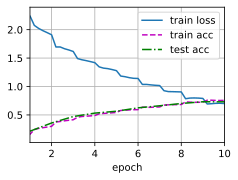

In [ ]:
# Takes about 15 min
lr, num_epochs = 0.05, 10
d2l.train_ch6(alexNet, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

**◦ CIFAR100**

In [ ]:
alexNet = nn.Sequential(
          nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),
          nn.MaxPool2d(kernel_size=3, stride=2),

          nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
          nn.MaxPool2d(kernel_size=3, stride=2),

          nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
          nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
          nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
          nn.MaxPool2d(kernel_size=3, stride=2), nn.Flatten(),

          nn.Linear(6400, 4096), nn.ReLU(), nn.Dropout(p=0.5),
          nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(p=0.5),
          # the number of classes : 100
          nn.Linear(4096, 100))

In [ ]:
X = torch.randn(1, 3, 224, 224)
for layer in alexNet:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Conv2d output shape:	 torch.Size([1, 96, 54, 54])
ReLU output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Conv2d output shape:	 torch.Size([1, 256, 26, 26])
ReLU output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 256, 12, 12])
ReLU output shape:	 torch.Size([1, 256, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 256, 5, 5])
Flatten output shape:	 torch.Size([1, 6400])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1,

In [ ]:
batch_size = 128
train_iter, test_iter = load_data_cifar100(batch_size, resize=224)

loss 2.817, train acc 0.295, test acc 0.307
362.1 examples/sec on cuda:0


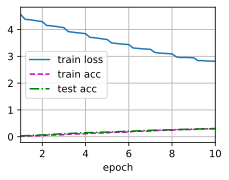

In [ ]:
# Takes about 27 min
lr, num_epochs = 0.03, 10
d2l.train_ch6(alexNet, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

> ### **2. VGG-Net Model**

**◦ CIFAR10**

In [ ]:
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))
vggNet = vgg(conv_arch,10)

X = torch.randn(size=(1, 3, 224, 224))
for blk in vggNet:
    X = blk(X)
    print(blk.__class__.__name__, 'output shape:      \t', X.shape)

Sequential output shape:      	 torch.Size([1, 64, 112, 112])
Sequential output shape:      	 torch.Size([1, 128, 56, 56])
Sequential output shape:      	 torch.Size([1, 256, 28, 28])
Sequential output shape:      	 torch.Size([1, 512, 14, 14])
Sequential output shape:      	 torch.Size([1, 512, 7, 7])
Flatten output shape:      	 torch.Size([1, 25088])
Linear output shape:      	 torch.Size([1, 4096])
ReLU output shape:      	 torch.Size([1, 4096])
Dropout output shape:      	 torch.Size([1, 4096])
Linear output shape:      	 torch.Size([1, 4096])
ReLU output shape:      	 torch.Size([1, 4096])
Dropout output shape:      	 torch.Size([1, 4096])
Linear output shape:      	 torch.Size([1, 10])


In [ ]:
ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
vggNet = vgg(small_conv_arch,10)

loss 0.813, train acc 0.714, test acc 0.673
345.0 examples/sec on cuda:0


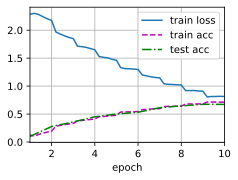

In [ ]:
# Takes about 28 min
lr, num_epochs, batch_size = 0.05, 10, 128
train_iter, test_iter = load_data_cifar10(batch_size, resize=224)
d2l.train_ch6(vggNet, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

**◦ CIFAR100**

In [ ]:
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))
vggNet = vgg(conv_arch,100)

X = torch.randn(size=(1, 3, 224, 224))
for blk in vggNet:
    X = blk(X)
    print(blk.__class__.__name__, 'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 100])


In [ ]:
ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
vggNet = vgg(small_conv_arch,100)

loss 2.790, train acc 0.307, test acc 0.331
346.8 examples/sec on cuda:0


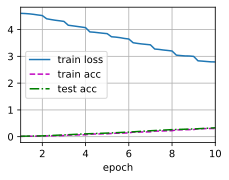

In [ ]:
# Takes about 28 min
lr, num_epochs, batch_size = 0.05, 10, 128
train_iter, test_iter = load_data_cifar100(batch_size, resize=224)
d2l.train_ch6(vggNet, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

> ### **3. NiN Model**

**◦ CIFAR10**

In [10]:
nin = nn.Sequential(
      nin_block(3, 96, kernel_size=11, strides=4, padding=0),
      nn.MaxPool2d(3, stride=2),
      nin_block(96, 256, kernel_size=5, strides=1, padding=2),
      nn.MaxPool2d(3, stride=2),
      nin_block(256, 384, kernel_size=3, strides=1, padding=1),
      nn.MaxPool2d(3, stride=2), nn.Dropout(0.5),
      # There are 10 label classes
      nin_block(384, 10, kernel_size=3, strides=1, padding=1),
      nn.AdaptiveAvgPool2d((1, 1)),
      # output shape : (batch size, 10)
      nn.Flatten())

In [11]:
X = torch.rand(size=(1, 3, 224, 224))
for layer in nin:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:   \t', X.shape)

Sequential output shape:   	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:   	 torch.Size([1, 96, 26, 26])
Sequential output shape:   	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:   	 torch.Size([1, 256, 12, 12])
Sequential output shape:   	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape:   	 torch.Size([1, 384, 5, 5])
Dropout output shape:   	 torch.Size([1, 384, 5, 5])
Sequential output shape:   	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d output shape:   	 torch.Size([1, 10, 1, 1])
Flatten output shape:   	 torch.Size([1, 10])


loss 1.567, train acc 0.447, test acc 0.476
325.0 examples/sec on cuda:0


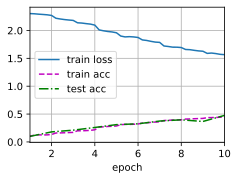

In [12]:
# Takes about 29 min
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = load_data_cifar10(batch_size, resize=224)
d2l.train_ch6(nin, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

**◦ CIFAR100**

In [22]:
nin = nn.Sequential(
      nin_block(3, 96, kernel_size=11, strides=4, padding=0),
      nn.MaxPool2d(3, stride=2),
      nin_block(96, 256, kernel_size=5, strides=1, padding=2),
      nn.MaxPool2d(3, stride=2),
      nin_block(256, 384, kernel_size=3, strides=1, padding=1),
      nn.MaxPool2d(3, stride=2), nn.Dropout(0.5),
      # There are 100 label classes
      nin_block(384, 100, kernel_size=3, strides=1, padding=1),
      nn.AdaptiveAvgPool2d((1, 1)),
      # output shape : (batch size, 100)
      nn.Flatten())

In [23]:
X = torch.rand(size=(1, 3, 224, 224))
for layer in nin:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:   \t', X.shape)

Sequential output shape:   	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:   	 torch.Size([1, 96, 26, 26])
Sequential output shape:   	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:   	 torch.Size([1, 256, 12, 12])
Sequential output shape:   	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape:   	 torch.Size([1, 384, 5, 5])
Dropout output shape:   	 torch.Size([1, 384, 5, 5])
Sequential output shape:   	 torch.Size([1, 100, 5, 5])
AdaptiveAvgPool2d output shape:   	 torch.Size([1, 100, 1, 1])
Flatten output shape:   	 torch.Size([1, 100])


loss 3.762, train acc 0.127, test acc 0.144
322.0 examples/sec on cuda:0


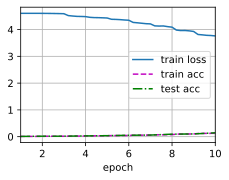

In [24]:
# Takes about 30 min
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = load_data_cifar100(batch_size, resize=224)
d2l.train_ch6(nin, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

> ### **4. Compare Training Results**

- #### **AlexNet Model**
  - CIFAR10 : loss 0.700, train acc 0.756, test acc 0.731
  - CIFAR100 : loss 2.817, train acc 0.295, test acc 0.307

- #### **VGG-Net Model**
  - CIFAR10 : loss 0.813, train acc 0.714, test acc 0.673
  - CIFAR100 : loss 2.790, train acc 0.307, test acc 0.331

- #### **NiN Model**
  - CIFAR10 : loss 1.567, train acc 0.447, test acc 0.476
  - CIFAR100 : loss 3.762, train acc 0.127, test acc 0.144

- #### **Accuracy**
  - CIFAR10 : AlexNet > VGG-Net > Nin
  - CIFAR100 :  VGG-Net > AlexNet > Nin

> ### **5.Visualize a few training images together with their class names, for CIFAR10 and CIFAR100, respectively.**

In [ ]:
batch_size = 128
train_iter, test_iter = load_data_cifar10(batch_size)

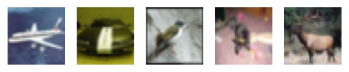

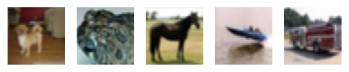

In [ ]:
label = 0; images = []
for data in train_iter:
  x,y = data
  if y[0].item() == label:
    images.append(x[0])
    label += 1
  if label == 10: break

fig1 = plt.figure()
rows,cols = 1,5
for i in range(5):
  ax1 = fig1.add_subplot(rows, cols, i+1)
  ax1.imshow(images[i].permute(1, 2, 0))
  ax1.axis("off")
plt.show()

fig2 = plt.figure()
rows,cols = 1,5
for i in range(5):
  ax1 = fig2.add_subplot(rows, cols, i+1)
  ax1.imshow(images[i+5].permute(1, 2, 0))
  ax1.axis("off")
plt.show()

> **< CIFAR10 Lables >**
- airplane : 0 / automobile : 1 / bird : 2 / cat : 3 / deer : 4
- dog : 5 / frog : 6 / horse : 7 / ship : 8 / truck : 9

In [ ]:
batch_size = 128
train_iter, test_iter = load_data_cifar100(batch_size)

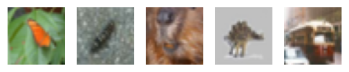

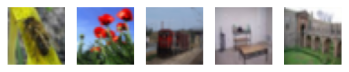

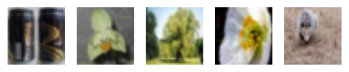

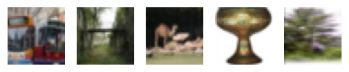

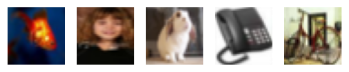

In [ ]:
label = 0; images = []
for data in train_iter:
  x,y = data
  for j in y:
    if j.item() == label:
      images.append(x[0])
      label += 1
      break
  if label == 100: break

# Label 1~5
fig1 = plt.figure()
rows,cols = 1,5
for i in range(5):
  ax1 = fig1.add_subplot(rows, cols, i+1)
  ax1.imshow(images[i].permute(1, 2, 0))
  ax1.axis("off")
plt.show()

# Label 6~10
fig2 = plt.figure()
rows,cols = 1,5
for i in range(5):
  ax1 = fig2.add_subplot(rows, cols, i+1)
  ax1.imshow(images[i+5].permute(1, 2, 0))
  ax1.axis("off")
plt.show()

# Label 11~15
fig3 = plt.figure()
rows,cols = 1,5
for i in range(5):
  ax1 = fig3.add_subplot(rows, cols, i+1)
  ax1.imshow(images[i+10].permute(1, 2, 0))
  ax1.axis("off")
plt.show()

# Label 16~20
fig4 = plt.figure()
rows,cols = 1,5
for i in range(5):
  ax1 = fig4.add_subplot(rows, cols, i+1)
  ax1.imshow(images[i+15].permute(1, 2, 0))
  ax1.axis("off")
plt.show()

# Label 21~25
fig5 = plt.figure()
rows,cols = 1,5
for i in range(5):
  ax1 = fig5.add_subplot(rows, cols, i+1)
  ax1.imshow(images[i+20].permute(1, 2, 0))
  ax1.axis("off")
plt.show()

**< CIFAR100 Lables >**

0   | Superclass         | Classes
----|--------------------|------------------
1 | aquatic mammals	| beaver, dolphin, otter, seal, whale
2 | fish	| aquarium fish, flatfish, ray, shark, trout
3 | flowers	| orchids, poppies, roses, sunflowers, tulips
4 | food | containers	bottles, bowls, cans, cups, plates
5 | fruit and vegetables | apples, mushrooms, oranges, pears, sweet peppers
6 | household electrical devices | clock, computer keyboard, lamp, telephone, television
7 | household furniture	| bed, chair, couch, table, wardrobe
8 | insects	| bee, beetle, butterfly, caterpillar, cockroach
9 | large carnivores |	bear, leopard, lion, tiger, wolf
10 | large man-made outdoor things	| bridge, castle, house, road, skyscraper
11 | large natural outdoor scenes	| cloud, forest, mountain, plain, sea
12 | large omnivores and herbivores	| camel, cattle, chimpanzee, elephant, kangaroo
13 | medium-sized mammals	| fox, porcupine, possum, raccoon, skunk
14 | non-insect invertebrates	| crab, lobster, snail, spider, worm
15 | people	| baby, boy, girl, man, woman
16 | reptiles |	crocodile, dinosaur, lizard, snake, turtle
17 | small mammals	| hamster, mouse, rabbit, shrew, squirrel
18 | trees	| maple, oak, palm, pine, willow
19 | vehicles 1	| bicycle, bus, motorcycle, pickup truck, train
20 | vehicles 2	| lawn-mower, rocket, streetcar, tank, tractor

<br>